# Template for Practical work on the Conversion of sampling frequency and STFT


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2020*

**python version : 3.6**

# Practical Work on the Conversion of sampling frequency and STFT
### Clément DARDARE & Jeanne MALÉCOT

In [1]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write

## Functions

In [27]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [28]:
data_path = os.getcwd()
filename = 'caravan_48khz.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [29]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')


In [57]:
play = True
if play :
    play_sound(sound) 

In [31]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [32]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

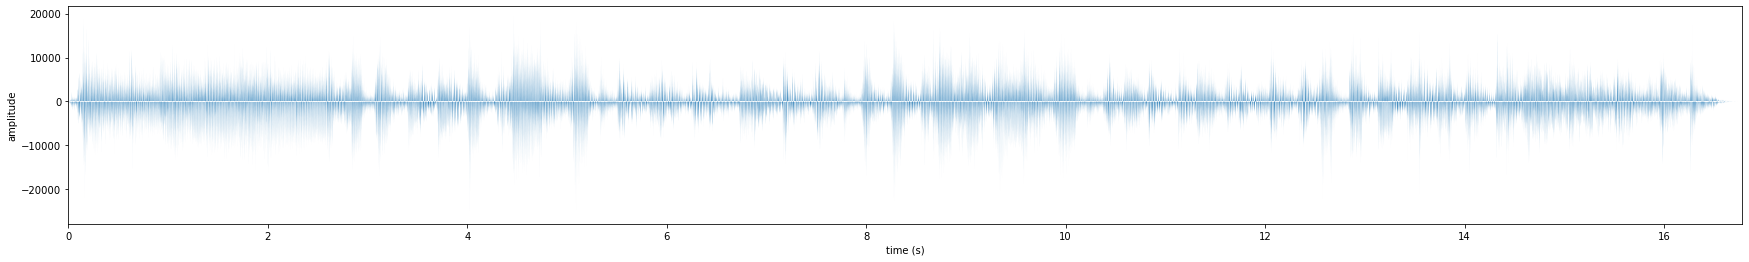

In [33]:
plot_sound(x, times)

In [34]:
write('new_caravan.wav', Fs, np.array(x, dtype=np.int16)) # to write a new wave file

## Conversion of sampling rate

### Question 1 

32/48 = 2/3 -> we have to upsample by 2, apply the filter and then downsample by 3.

In [63]:
def filter(x):
    N = 20
    nu_c = 1/6-0.01 #1/(2*M) (M=3 and L=2)
    h = scipy.signal.remez(N,[0,nu_c,nu_c+0.02,.5],[2,0])
    xFiltre = np.convolve(x,h)

    return xFiltre

#### Let's verify h

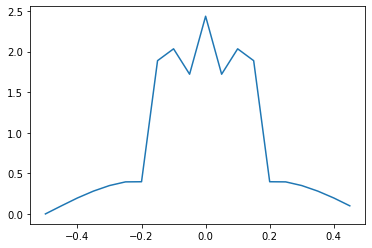

In [68]:
N = 20
nu_c = (1/6)-0.01 
h = scipy.signal.remez(N,[0,nu_c,nu_c+0.02,.5],[2,0])
H = np.abs(np.fft.fft(h))

Hsize = H.shape[0]

H = np.concatenate((H[Hsize//2 : Hsize], H[0:Hsize//2]))
abs = np.arange(-Hsize//2, Hsize//2)/Hsize

plt.plot(abs, H)
plt.show()

In [37]:
def upsampling(x, L):
    xSize = x.shape[0]
    newSize = int(xSize * L)
    XUpsampled = np.zeros(newSize)
    XUpsampled[np.arange(xSize)*L] = x

    return XUpsampled

### Question  2

In [38]:
def downsampling(x, M):
    return [x[M*i] for i in range(x.shape[0]//M)]

In [39]:
def resampling(x, L, M):
    xResample = upsampling(x, L)
    xResample = filter(xResample)
    xResample = downsampling(xResample, M)

    return xResample

### Question 3

In [40]:
%%time

x0=np.zeros(x.shape[0]//3)
x1=np.zeros(x.shape[0]//3)
x2=np.zeros(x.shape[0]//3)

for i in range(x.shape[0]//3):
    x0[i]=x[i*3]
    x1[i]=x[i*3+1]
    x2[i]=x[i*3+2]

R0 = np.zeros(h.shape[0]//2)
R1 = np.zeros(h.shape[0]//2)

for j in range(h.shape[0]//2):
    R0[j]=h[j*2]
    R1[j]=h[j*2+1]

E00=np.zeros(R0.shape[0]//3)
E01=np.zeros(R0.shape[0]//3)
E02=np.zeros(R0.shape[0]//3)

E10=np.zeros(R1.shape[0]//3)
E11=np.zeros(R1.shape[0]//3)
E12=np.zeros(R1.shape[0]//3)

for i in range(R1.shape[0]//3):
    E10[i]=R1[i*3]
    E11[i]=R1[i*3+1]
    E12[i]=R1[i*3+2]
    E00[i]=R0[i*3]
    E01[i]=R0[i*3+1]
    E02[i]=R0[i*3+2]

E00 = np.convolve(E00,x0)
E01 = np.convolve(E01,x1)
E02 = np.convolve(E02,x2)

E10 = np.convolve(E10,x0)
E11 = np.convolve(E11,x1)
E12 = np.convolve(E12,x2)

E0 = E00+E01+E02
E1 = E10+E11+E12

E0 = upsampling(E0,2)
E0 = np.insert(E0,0,0)

E1 = upsampling(E1,2)
E1 = np.append(E1,0)

xPolyphase = E0+E1

CPU times: total: 281 ms
Wall time: 280 ms


### Question 4 

In [41]:
write('new_caravan.wav', Fs, np.array(resampling(x, 2, 3), dtype=np.int16))
write('new_caravan_polyphase.wav', Fs, np.array(xPolyphase, dtype=np.int16))

In [42]:
filename = 'new_caravan.wav'
sound = os.path.join(data_path, filename) 
wavefile = load_sound(sound)
print(wavefile.getparams())
play = True
if play :
    play_sound(sound) 

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=537161, comptype='NONE', compname='not compressed')


In [43]:
filename = 'new_caravan_polyphase.wav'
sound = os.path.join(data_path, filename) 
wavefile = load_sound(sound)
print(wavefile.getparams())
play = True
if play :
    play_sound(sound) 

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=537159, comptype='NONE', compname='not compressed')


In [44]:
%%time

xresemple = resampling(x, 2, 3)

CPU times: total: 141 ms
Wall time: 137 ms


## Signal analysis with the STFT

### Question 1


C:\Users\jeann\AppData\Local\Temp\ipykernel_18172\1750927833.py:10: RuntimeWarning: divide by zero encountered in log10
  wdft = 20*np.log10(wdft/wdft.max())


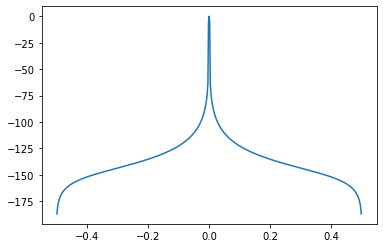

In [45]:
from numpy import concatenate


Nw = 512
w=np.hanning(Nw)
M=512
w_tilde=np.abs(np.fft.fft(w,M))

wdft = np.concatenate((w_tilde[M//2:M],w_tilde[0:M//2]))
wdft = 20*np.log10(wdft/wdft.max())

abs = np.arange(-0.5,0.5, 1/M)

plt.plot(abs,wdft)
plt.show()

### Question 2

We can notice in the compute of tx, that there is a shift of *+u***R*, whitch correspond to *+b* in the statement. We conclude that the band-pass is the one implemented in the code below.

In [49]:
N = x.shape[0] # % longueur du signal
Nw = 512
w = np.hanning(Nw) # définition de la fenetre d'analyse
ws = w.copy; # définition de la fenêtre de synthèse
R = 1 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
M = 32 # ordre de la tfd
L = M/2+1
affich = 1 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse

if affich:
    Xtilde = np.zeros((M,Nt),dtype=complex)

In [50]:
for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 # début de trame
    fin = deb + Nw # fin de trame
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # calcul de la trame 
    X = np.fft.fft(tx,M) # tfd à l'instant b
    if affich:
        Xtilde[:,u] = X
    # opérations de transformation (sur la partie \nu > 0)
    # ....
    Y = X.copy
    # fin des opérations de transformation
    # resynthèse
    # overlap add

def extents(f):
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]

### Question 3

In [51]:
xk = Xtilde[2,:]
print(xk)

[ 0.10774322-0.13855851j  0.10776922-0.0947159j   0.09179041-0.05744169j
 ... -0.05939334+0.02348439j -0.05866737-0.00086117j
 -0.0493627 -0.02121201j]


xk are complex.

c:\Users\jeann\anaconda3\lib\site-packages\scipy\signal\spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


 ...]

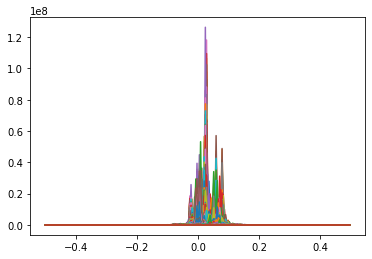

In [53]:
plt.figure()
Sx=scipy.signal.spectrogram((xk))[2]
lg=len(Sx)
Sx=np.concatenate([Sx[lg//2:],Sx[:lg//2]])

abs=np.arange(-lg//2,lg//2)/lg
plt.plot(abs,Sx)


c:\Users\jeann\anaconda3\lib\site-packages\scipy\signal\spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


 ...]

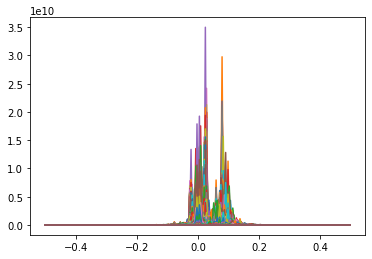

In [54]:
filtre=scipy.signal.lfilter([1], [1,-0.9*np.exp(2j*np.pi*3/32)],x)
plt.figure()
Sf=scipy.signal.spectrogram((filtre))[2]
lg=len(Sf)
Sf=np.concatenate([Sf[lg//2:],Sf[:lg//2]])

abs=np.arange(-lg//2,lg//2)/lg
plt.plot(abs,Sf)

3/32 filter and 3rd component of Xtilde have the same aspect.

In [60]:
XtildeReal= np.real(xk)
write('Xtilde.wav',Fs, np.array(XtildeReal, dtype=np.int16))
filename = 'Xtilde.wav'
sound = os.path.join(data_path, filename) 
wavefile = load_sound(sound)
print(wavefile.getparams())
play = True
if play :
    play_sound(sound) 

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805221, comptype='NONE', compname='not compressed')


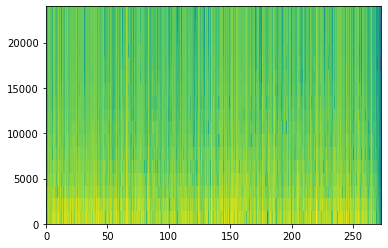

In [62]:
if affich:
    plt.imshow(20*np.log10(np.abs(Xtilde[np.arange(0,L).astype(int),:])), aspect='auto',interpolation='none',
               origin='lower', extent=[0, Nt * R / Fs + Nw / 2, 0, Fs/2])
    

Re(xk) sounds like the original sound.

## Overlap-add reconstruction

In [73]:
def ola(w = None,hop = None,Nb = 10): 
# function output = ola(w,hop,Nb)
# realise l'addition-recouvrement de la fenetre w,
# avec un décalage hop et un nombre Nb de fenetres.
# par defaut Nb = 10;
    
    w = w[:, np.newaxis]
    N = len(w)
    output = np.zeros(((Nb - 1) * hop + N,1)) # réserve l'espace memoire
    
    for k in np.arange(0,Nb).reshape(-1):
        deb = k* hop
        fin = deb + N
        output[np.arange(deb,fin)] = output[np.arange(deb,fin)] + w # OLA
    
    return output

1.0171875


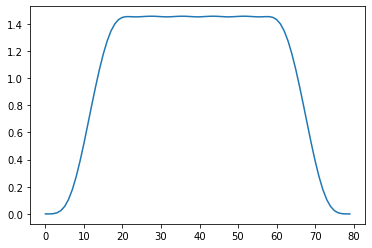

In [97]:
Nw=32

w = np.hanning(Nw)
ws=w.copy()
wp=np.multiply(w,ws)

wola=ola(wp,Nw//4,(Nw-1)//4)
print(wola.mean())
plt.plot(wola)